In [1]:
# Assume that pyCDCS and lxml are already installed
import cdcs
import pandas as pd
import lxml.etree as et
import requests
import json

# define which MRR instances to query
nmrr_instance = cdcs.CDCS('https://materials.registry.nist.gov/', username='')
mdf_mrr_instance = cdcs.CDCS('https://mrr.materialsdatafacility.org/', username='')

# define search parameters
search_string = 'optimade'
# oqmd URL = 'http://oqmd.org/optimade/structures?filter=_oqmd_band_gap=0'
# optimade_query = 'optimade/structures?filter=_oqmd_band_gap=0'

# oqmd URL = 'http://oqmd.org/optimade/v1/structures?filter=chemical_formula_reduced=%22O2Si%22'
optimade_query = 'optimade/v1/structures?filter=chemical_formula_reduced=%22O2Si%22'

# query MRR instances
records_nmrr = nmrr_instance.query(mongoquery={"$text":{"$search": search_string}})
records_mdf = mdf_mrr_instance.query(mongoquery={"$text":{"$search": search_string}})

returned_results = [records_nmrr, records_mdf]
records = pd.concat(returned_results)
records

,id,template,workspace,user_id,title,xml_content,creation_date,last_modification_date,last_change_date,template_title
0,61e6b7876e07c8cff02ec404,61e6b6d3051f5e060530b206,61e6b6d3051f5e060530b205,53,optimade-python-tools,"<Resource xmlns:xsi=""http://www.w3.org/2001/XM...",2021-12-02T21:27:43.420000Z,2021-12-02T21:28:44.562000Z,2021-12-02T21:28:44.400000Z,res-md.xsd
0,61e6c52048175bd317b973a7,61e6c4a1266710654b351df2,61e6c4b06be34c420cd142f0,6,oqmd.xml,"<Resource xmlns:xsi=""http://www.w3.org/2001/XM...",2021-12-22T20:26:31.744000Z,2022-02-01T15:04:27.462000Z,2022-02-01T15:04:27.413000Z,res-md.xsd


In [2]:
# parse returned MRR records using the lxml etree library
# for each matching record, perform query via the API (if applicable)

num_returned_records = records.shape[0]

for r in range(0,num_returned_records):
    print(records.iloc[r].title)
    xml_root = et.fromstring(records.iloc[r].xml_content)
    #print(records.iloc[r].xml_content)
    
    # map 'default_ns' to the MRR res-md schema 
    # (e.g., 'http://schema.nist.gov/xml/res-md/1.0wd-02-2017')
    # to support queries.
    # lxml info and tutorials: https://lxml.de/tutorial.html
    
    nsmap = {('default_ns',ns[1]) for ns in xml_root.xpath('//namespace::*') if (ns[0]==None)}
    
    # if baseURL is not empty, then perform query of that resource
    for link in xml_root.xpath(".//default_ns:baseURL", namespaces=nsmap):
        if link.text == 'http://oqmd.org/optimade':
            baseURL = 'http://oqmd.org/' + optimade_query
            print('baseURL: ', baseURL)
            r = requests.get(baseURL)
            results_json = r.json()            
            #print(json.dumps(results_json, indent=4))


optimade-python-tools
oqmd.xml
baseURL:  http://oqmd.org/optimade/v1/structures?filter=chemical_formula_reduced=%22O2Si%22


In [3]:
# parse OQMD results

list(results_json)

['links', 'resource', 'data', 'meta']

In [4]:
len(results_json["data"])

50

In [5]:
results_json["data"][0]

{'id': 4065228,
 'type': 'structures',
 'attributes': {'last_modified': None,
  'chemical_formula_reduced': 'O2Si',
  'chemical_formula_anonymous': 'A2B',
  'nelements': 2,
  'elements': ['O', 'Si'],
  'nsites': 3,
  'lattice_vectors': [[2.268732, -2.268732, 0.0],
   [-2.268732, 0.0, -2.268732],
   [2.268732, 2.268732, 0.0]],
  'species_at_sites': ['O', 'O', 'Si'],
  'nperiodic_dimensions': 3,
  'structure_features': [],
  'chemical_formula_descriptive': 'O2Si',
  'cartesian_site_positions': [[1.13437, -1.13437, -1.13437],
   [1.13437, 1.13437, -1.13437],
   [0.0, 0.0, 0.0]],
  '_oqmd_entry_id': 8352,
  '_oqmd_calculation_id': 8668,
  '_oqmd_icsd_id': 44271,
  '_oqmd_band_gap': 2.245,
  '_oqmd_delta_e': -1.813,
  '_oqmd_volume': 23.355,
  '_oqmd_stability': 1.261,
  '_oqmd_prototype': 'CaF2',
  '_oqmd_spacegroup': 'Fm-3m'}}

In [6]:
#results_json["meta"]

In [7]:
df = pd.DataFrame(columns=['_oqmd_volume', '_oqmd_band_gap'])

for i in range(0,len(results_json["data"])):
    vol = results_json["data"][i].get('attributes').get('_oqmd_volume')
    band_gap = results_json["data"][i].get('attributes').get('_oqmd_band_gap')
    #print(vol, band_gap)
    # append to dataframe...
    df = df.append({'_oqmd_volume': vol,'_oqmd_band_gap': band_gap}, ignore_index=True)
    
df

,_oqmd_volume,_oqmd_band_gap
0,23.3550,2.245
1,101.0910,5.596
2,82.5578,6.374
3,83.4472,6.268
4,121.1590,5.869
5,122.1390,5.745
6,109.7350,6.152
7,109.0520,6.095
8,109.6590,6.054
9,526.4620,6.081


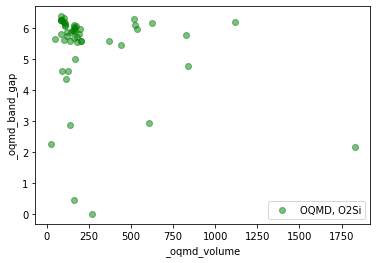

In [8]:
# plot returned data.

import matplotlib.pyplot as plt
import numpy as np
plt.scatter(df["_oqmd_volume"], df["_oqmd_band_gap"], c="g", alpha=0.5, label="OQMD, O2Si")
plt.xlabel("_oqmd_volume")
plt.ylabel("_oqmd_band_gap")
plt.legend(loc='lower right')
plt.show()